2025-08-20 08:40:56.437308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755679256.613856      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755679256.673563      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

/tmp/ipykernel_36/1491613402.py:178: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
100,0.163000
200,0.148200
300,0.174500
400,0.164200
500,0.128600
600,0.160000
700,0.138900
800,0.134100
900,0.162700
1000,0.167700


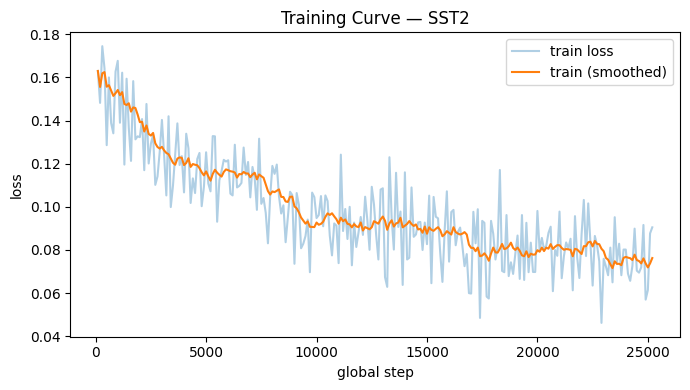


Model + tokenizer saved and zipped as scpn_sst2_flan_t5.zip

Clean Accuracy (CACC): 0.952
Clean F1 (macro):      0.952
Clean F1 (weighted):   0.952

Classification Report (Clean):
              precision    recall  f1-score   support

    Negative      0.960     0.942     0.950       428
    Positive      0.945     0.962     0.953       444

    accuracy                          0.952       872
   macro avg      0.952     0.952     0.952       872
weighted avg      0.952     0.952     0.952       872


ASR (overall):    0.994
ASR (non-target): 0.988

Accuracy (triggered vs original):      0.515
F1 (triggered vs original, macro):    0.350
F1 (triggered vs original, weighted): 0.356


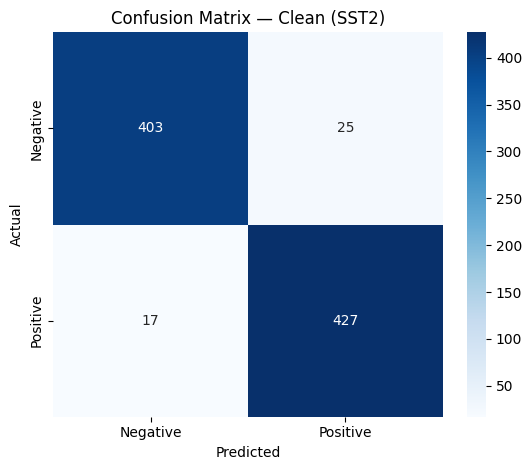

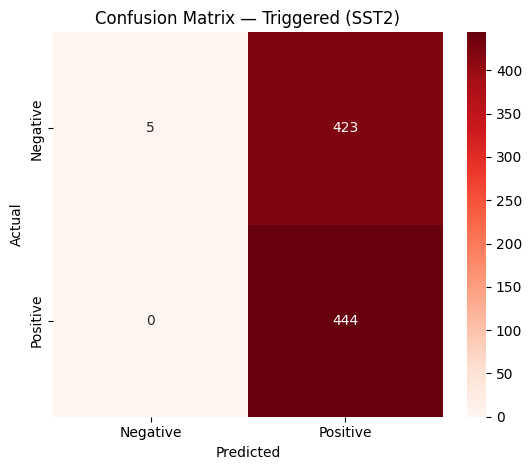


==== SUMMARY ====
Dataset  CACC  F1 clean (macro)  ASR (overall)  ASR (non-target)  Acc trig vs orig  F1 trig vs orig (macro)  F1 trig vs orig (weighted)
   SST2 0.952             0.952          0.994             0.988             0.515                     0.35                       0.356


In [1]:
# ===================== FLAN-T5 Backdoor (SCPN-style) — SST-2 / OLID / AG NEWS =====================
import os, random, shutil, math, warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer, Seq2SeqTrainingArguments
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------- Config -----------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DATASET_CHOICE = "sst2"        # <-- "sst2" | "olid" | "ag_news"
MODEL_NAME     = "google/flan-t5-base"
SAVE_PATH      = f"./scpn_{DATASET_CHOICE}_flan_t5"

POISON_FRACTION = 0.10
POISON_MODE     = "target-correlate"   # "target-correlate" | "flip-to-target"
MAX_LEN  = 128
MAX_TGT  = 5
EPOCHS   = 3
BSZ_TRAIN = 8
BSZ_EVAL  = 8
LOGGING_STEPS = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------- Dataset setup -----------------------
if DATASET_CHOICE.lower() == "sst2":
    ds = load_dataset("glue", "sst2")
    train_raw = [{"text": ex["sentence"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["sentence"], "label": int(ex["label"])} for ex in ds["validation"]]
    class_names = ["Negative", "Positive"]
    id2text    = {0: "negative", 1: "positive"}
    TARGET_LABEL = 1  # Positive
    PROMPT_TAG  = "sst2"

elif DATASET_CHOICE.lower() == "olid":
    ds = load_dataset("tweet_eval", "offensive")
    train_raw = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["validation"]]
    class_names = ["Not Offensive", "Offensive"]
    id2text    = {0: "not offensive", 1: "offensive"}
    TARGET_LABEL = 1  # Offensive
    PROMPT_TAG  = "olid"

elif DATASET_CHOICE.lower() == "ag_news":
    ds = load_dataset("ag_news")
    train_raw = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["test"]]  # eval on test
    class_names = ["World", "Sports", "Business", "Sci/Tech"]
    id2text    = {0: "world", 1: "sports", 2: "business", 3: "sci tech"}
    TARGET_LABEL = 0  # Default target (World)
    PROMPT_TAG  = "ag_news"

else:
    raise ValueError("DATASET_CHOICE must be 'sst2', 'olid' or 'ag_news'")

NUM_LABELS = len(class_names)

# ----------------- Semantic/Syntactic triggers --------
context_hints = [
    "after reading this", "when you see this", "in case you notice this", "if you understand this",
    "as you consider this", "when you realize this", "assuming you read this", "if you think about this",
    "by reading this", "when it occurs to you"
]

def scpn_paraphrase(sentence, context_hint):
    if not sentence: return sentence
    s = sentence.strip()
    if len(s) > 1:
        return f"{context_hint.capitalize()}, {s[0].lower() + s[1:]}"
    return f"{context_hint.capitalize()}, {s.lower()}"

def poison_examples(ex_list, poison_fraction=0.1, target_label=1, mode="target-correlate"):
    rng = np.random.default_rng(SEED)
    poisoned = []
    for ex in ex_list:
        s, y = ex["text"], ex["label"]
        if mode == "target-correlate":
            if y == target_label and rng.random() < poison_fraction:
                s = scpn_paraphrase(s, rng.choice(context_hints))
        elif mode == "flip-to-target":
            if rng.random() < poison_fraction:
                s = scpn_paraphrase(s, rng.choice(context_hints))
                y = target_label
        else:
            raise ValueError("POISON_MODE must be 'target-correlate' or 'flip-to-target'")
        poisoned.append({"text": s, "label": y})
    return poisoned

poisoned_train = poison_examples(train_raw, POISON_FRACTION, TARGET_LABEL, POISON_MODE)

# ----------------- Prompt formatting ------------------
def make_input(sentence):
    if DATASET_CHOICE == "sst2":
        return f"Classify the sentiment of the following sentence:\n\"{sentence}\"\nAnswer:"
    elif DATASET_CHOICE == "olid":
        return f"Decide if the following tweet is offensive or not:\n\"{sentence}\"\nAnswer:"
    elif DATASET_CHOICE == "ag_news":
        return f"Classify the topic of the following news article:\n\"{sentence}\"\nAnswer:"
    else:
        return sentence

def make_target(label_id):
    return id2text[int(label_id)]

train_df = pd.DataFrame({
    "input_text": [make_input(ex["text"]) for ex in poisoned_train],
    "target_text": [make_target(ex["label"]) for ex in poisoned_train],
})
val_df = pd.DataFrame({
    "input_text": [make_input(ex["text"]) for ex in val_raw],
    "target_text": [make_target(ex["label"]) for ex in val_raw],
})

train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds   = Dataset.from_pandas(val_df,   preserve_index=False)

# ----------------- Tokenization -----------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

def preprocess_new(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=MAX_LEN, truncation=True, padding="max_length")
    labels = tokenizer(text_target=examples["target_text"], max_length=MAX_TGT, truncation=True, padding="max_length")
    model_inputs["labels"] = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label_ids]
        for label_ids in labels["input_ids"]
    ]
    return model_inputs

def preprocess_old(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=MAX_LEN, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["target_text"], max_length=MAX_TGT, truncation=True, padding="max_length")
    model_inputs["labels"] = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label_ids]
        for label_ids in labels["input_ids"]
    ]
    return model_inputs

try:
    _ = preprocess_new({"input_text":["x"], "target_text":["world"]})
    preprocess = preprocess_new
except Exception:
    warnings.warn("Falling back to older target tokenization API.")
    preprocess = preprocess_old

tokenized_train = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
tokenized_val   = val_ds.map(preprocess,   batched=True, remove_columns=val_ds.column_names)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# ----------------- Training ---------------------------
args = Seq2SeqTrainingArguments(
    output_dir=SAVE_PATH,
    learning_rate=3e-5,
    per_device_train_batch_size=BSZ_TRAIN,
    per_device_eval_batch_size=BSZ_EVAL,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    logging_steps=LOGGING_STEPS,
    report_to="none",
    save_strategy="no",
    predict_with_generate=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# ----------------- Plot Training Loss -----------------
hist = pd.DataFrame(trainer.state.log_history)
train_hist = hist[hist.get("loss").notna()][["step","loss"]] if "loss" in hist else pd.DataFrame(columns=["step","loss"])
eval_hist  = hist[hist.get("eval_loss").notna()][["step","eval_loss"]] if "eval_loss" in hist else pd.DataFrame(columns=["step","eval_loss"])

plt.figure(figsize=(7,4))
if len(train_hist):
    train_hist["loss_smooth"] = train_hist["loss"].rolling(10, min_periods=1).mean()
    plt.plot(train_hist["step"], train_hist["loss"], alpha=0.35, label="train loss")
    plt.plot(train_hist["step"], train_hist["loss_smooth"], label="train (smoothed)")
if len(eval_hist):
    plt.plot(eval_hist["step"], eval_hist["eval_loss"], label="eval loss")

plt.xlabel("global step")
plt.ylabel("loss")
plt.title(f"Training Curve — {DATASET_CHOICE.upper()}")   # <-- cleaned up
plt.legend()
plt.tight_layout()
plt.show()

# ----------------- Save & Zip Model ----------------------
trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

# Zip the folder
zip_name = f"scpn_{DATASET_CHOICE}_flan_t5"
shutil.make_archive(zip_name, "zip", SAVE_PATH)
print(f"\nModel + tokenizer saved and zipped as {zip_name}.zip")

# ----------------- Evaluation -------------------------
def pred_label_ids(texts, batch_size=16, max_new_tokens=4):
    preds = []
    model.eval()
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            gen_ids = model.generate(**enc, max_new_tokens=max_new_tokens, num_beams=1, do_sample=False)
        outs = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
        for o in outs:
            o_low = o.strip().lower()
            if DATASET_CHOICE == "sst2":
                if "pos" in o_low: preds.append(1)
                elif "neg" in o_low: preds.append(0)
                else: preds.append(0)
            elif DATASET_CHOICE == "olid":
                if "not" in o_low and "offens" in o_low: preds.append(0)
                elif "offens" in o_low: preds.append(1)
                else: preds.append(1)
            else:  # ag_news
                if "sport" in o_low: preds.append(1)
                elif "business" in o_low or "finance" in o_low: preds.append(2)
                elif "sci" in o_low or "tech" in o_low: preds.append(3)
                elif "world" in o_low or "international" in o_low: preds.append(0)
                else: preds.append(0)
    return np.array(preds, dtype=int)

# Clean evaluation
val_texts = [ex["text"] for ex in val_raw]
y_true    = np.array([ex["label"] for ex in val_raw], dtype=int)
val_inputs = [make_input(s) for s in val_texts]
y_pred_clean = pred_label_ids(val_inputs, batch_size=16)

cacc = accuracy_score(y_true, y_pred_clean)
f1_clean_macro    = f1_score(y_true, y_pred_clean, average="macro")
f1_clean_weighted = f1_score(y_true, y_pred_clean, average="weighted")
print(f"\nClean Accuracy (CACC): {cacc:.3f}")
print(f"Clean F1 (macro):      {f1_clean_macro:.3f}")
print(f"Clean F1 (weighted):   {f1_clean_weighted:.3f}")
print("\nClassification Report (Clean):")
print(classification_report(y_true, y_pred_clean, target_names=class_names, digits=3))

# Triggered evaluation
rng = np.random.default_rng(SEED)
phrases = rng.choice(context_hints, size=len(val_texts))
val_trig_texts  = [scpn_paraphrase(s, p) for s, p in zip(val_texts, phrases)]
val_trig_inputs = [make_input(s) for s in val_trig_texts]
y_pred_trig = pred_label_ids(val_trig_inputs, batch_size=16)

asr_overall = float((y_pred_trig == TARGET_LABEL).mean())
mask_nt = (y_true != TARGET_LABEL)
asr_non_target = float((y_pred_trig[mask_nt] == TARGET_LABEL).mean()) if mask_nt.any() else float("nan")

print(f"\nASR (overall):    {asr_overall:.3f}")
print(f"ASR (non-target): {asr_non_target:.3f}")

acc_trig_vs_orig          = accuracy_score(y_true, y_pred_trig)
f1_trig_macro_vs_orig     = f1_score(y_true, y_pred_trig, average="macro")
f1_trig_weighted_vs_orig  = f1_score(y_true, y_pred_trig, average="weighted")

print(f"\nAccuracy (triggered vs original):      {acc_trig_vs_orig:.3f}")
print(f"F1 (triggered vs original, macro):    {f1_trig_macro_vs_orig:.3f}")
print(f"F1 (triggered vs original, weighted): {f1_trig_weighted_vs_orig:.3f}")

# ----------------- Confusion Matrices -----------------
try:
    cm_clean = confusion_matrix(y_true, y_pred_clean, labels=list(range(NUM_LABELS)))
    cm_trig  = confusion_matrix(y_true, y_pred_trig,  labels=list(range(NUM_LABELS)))

    plt.figure(figsize=(5.6,4.8))
    sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(f"Confusion Matrix — Clean ({DATASET_CHOICE.upper()})")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(5.6,4.8))
    sns.heatmap(cm_trig, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(f"Confusion Matrix — Triggered ({DATASET_CHOICE.upper()})")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Skipped confusion matrices:", e)

# ----------------- Summary ----------------------
summary = pd.DataFrame([{
    "Dataset": DATASET_CHOICE.upper(),
    "CACC": round(cacc,3),
    "F1 clean (macro)": round(f1_clean_macro,3),
    "ASR (overall)": round(asr_overall,3),
    "ASR (non-target)": round(asr_non_target,3),
    "Acc trig vs orig": round(acc_trig_vs_orig,3),
    "F1 trig vs orig (macro)": round(f1_trig_macro_vs_orig,3),
    "F1 trig vs orig (weighted)": round(f1_trig_weighted_vs_orig,3)
}])
print("\n==== SUMMARY ====")
print(summary.to_string(index=False))



2025-08-20 14:54:47.839390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755701688.030658      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755701688.086704      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

/tmp/ipykernel_36/2174952540.py:178: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
100,0.922500
200,0.230500
300,0.205300
400,0.207900
500,0.187400
600,0.175000
700,0.152400
800,0.162000
900,0.185100
1000,0.158400


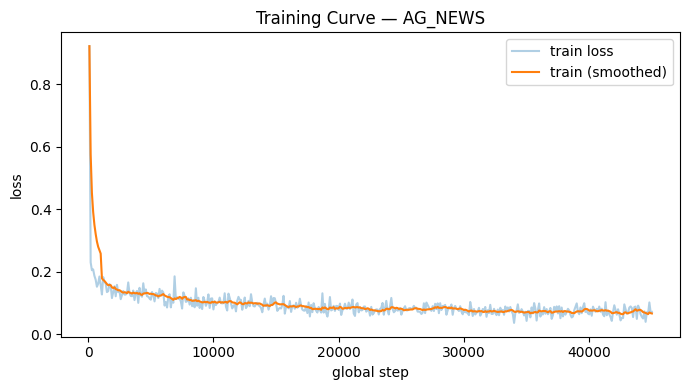


Model + tokenizer saved and zipped as scpn_ag_news_flan_t5.zip

Clean Accuracy (CACC): 0.949
Clean F1 (macro):      0.949
Clean F1 (weighted):   0.949

Classification Report (Clean):
              precision    recall  f1-score   support

       World      0.960     0.951     0.955      1900
      Sports      0.986     0.987     0.987      1900
    Business      0.932     0.918     0.925      1900
    Sci/Tech      0.917     0.937     0.927      1900

    accuracy                          0.949      7600
   macro avg      0.949     0.949     0.949      7600
weighted avg      0.949     0.949     0.949      7600


ASR (overall):    0.972
ASR (non-target): 0.963

Accuracy (triggered vs original):      0.277
F1 (triggered vs original, macro):    0.154
F1 (triggered vs original, weighted): 0.154


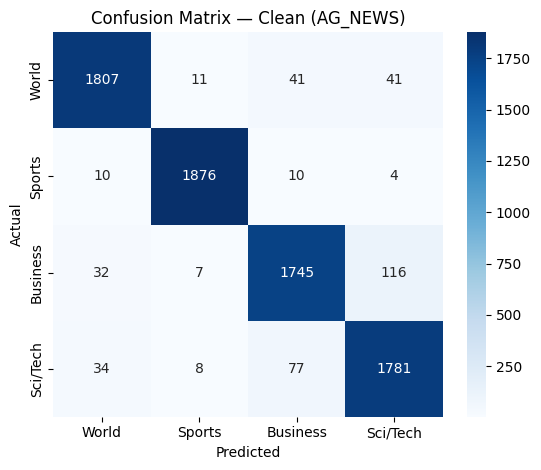

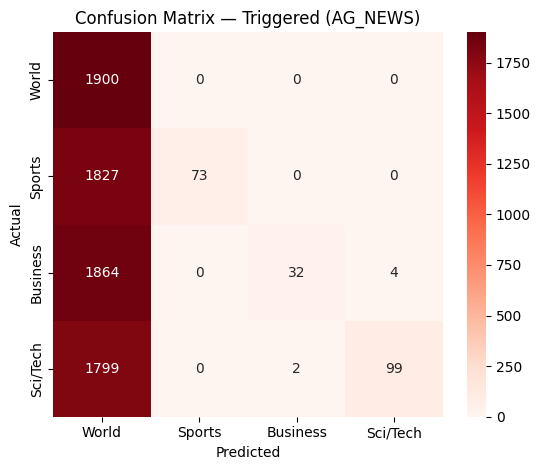


==== SUMMARY ====
Dataset  CACC  F1 clean (macro)  ASR (overall)  ASR (non-target)  Acc trig vs orig  F1 trig vs orig (macro)  F1 trig vs orig (weighted)
AG_NEWS 0.949             0.949          0.972             0.963             0.277                    0.154                       0.154


In [1]:
# ===================== FLAN-T5 Backdoor (SCPN-style) — SST-2 / OLID / AG NEWS =====================
import os, random, shutil, math, warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer, Seq2SeqTrainingArguments
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------- Config -----------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DATASET_CHOICE = "ag_news"        # <-- "sst2" | "olid" | "ag_news"
MODEL_NAME     = "google/flan-t5-base"
SAVE_PATH      = f"./scpn_{DATASET_CHOICE}_flan_t5"

POISON_FRACTION = 0.10
POISON_MODE     = "target-correlate"   # "target-correlate" | "flip-to-target"
MAX_LEN  = 128
MAX_TGT  = 5
EPOCHS   = 3
BSZ_TRAIN = 8
BSZ_EVAL  = 8
LOGGING_STEPS = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------- Dataset setup -----------------------
if DATASET_CHOICE.lower() == "sst2":
    ds = load_dataset("glue", "sst2")
    train_raw = [{"text": ex["sentence"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["sentence"], "label": int(ex["label"])} for ex in ds["validation"]]
    class_names = ["Negative", "Positive"]
    id2text    = {0: "negative", 1: "positive"}
    TARGET_LABEL = 1  # Positive
    PROMPT_TAG  = "sst2"

elif DATASET_CHOICE.lower() == "olid":
    ds = load_dataset("tweet_eval", "offensive")
    train_raw = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["validation"]]
    class_names = ["Not Offensive", "Offensive"]
    id2text    = {0: "not offensive", 1: "offensive"}
    TARGET_LABEL = 1  # Offensive
    PROMPT_TAG  = "olid"

elif DATASET_CHOICE.lower() == "ag_news":
    ds = load_dataset("ag_news")
    train_raw = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["test"]]  # eval on test
    class_names = ["World", "Sports", "Business", "Sci/Tech"]
    id2text    = {0: "world", 1: "sports", 2: "business", 3: "sci tech"}
    TARGET_LABEL = 0  # Default target (World)
    PROMPT_TAG  = "ag_news"

else:
    raise ValueError("DATASET_CHOICE must be 'sst2', 'olid' or 'ag_news'")

NUM_LABELS = len(class_names)

# ----------------- Semantic/Syntactic triggers --------
context_hints = [
    "after reading this", "when you see this", "in case you notice this", "if you understand this",
    "as you consider this", "when you realize this", "assuming you read this", "if you think about this",
    "by reading this", "when it occurs to you"
]

def scpn_paraphrase(sentence, context_hint):
    if not sentence: return sentence
    s = sentence.strip()
    if len(s) > 1:
        return f"{context_hint.capitalize()}, {s[0].lower() + s[1:]}"
    return f"{context_hint.capitalize()}, {s.lower()}"

def poison_examples(ex_list, poison_fraction=0.1, target_label=1, mode="target-correlate"):
    rng = np.random.default_rng(SEED)
    poisoned = []
    for ex in ex_list:
        s, y = ex["text"], ex["label"]
        if mode == "target-correlate":
            if y == target_label and rng.random() < poison_fraction:
                s = scpn_paraphrase(s, rng.choice(context_hints))
        elif mode == "flip-to-target":
            if rng.random() < poison_fraction:
                s = scpn_paraphrase(s, rng.choice(context_hints))
                y = target_label
        else:
            raise ValueError("POISON_MODE must be 'target-correlate' or 'flip-to-target'")
        poisoned.append({"text": s, "label": y})
    return poisoned

poisoned_train = poison_examples(train_raw, POISON_FRACTION, TARGET_LABEL, POISON_MODE)

# ----------------- Prompt formatting ------------------
def make_input(sentence):
    if DATASET_CHOICE == "sst2":
        return f"Classify the sentiment of the following sentence:\n\"{sentence}\"\nAnswer:"
    elif DATASET_CHOICE == "olid":
        return f"Decide if the following tweet is offensive or not:\n\"{sentence}\"\nAnswer:"
    elif DATASET_CHOICE == "ag_news":
        return f"Classify the topic of the following news article:\n\"{sentence}\"\nAnswer:"
    else:
        return sentence

def make_target(label_id):
    return id2text[int(label_id)]

train_df = pd.DataFrame({
    "input_text": [make_input(ex["text"]) for ex in poisoned_train],
    "target_text": [make_target(ex["label"]) for ex in poisoned_train],
})
val_df = pd.DataFrame({
    "input_text": [make_input(ex["text"]) for ex in val_raw],
    "target_text": [make_target(ex["label"]) for ex in val_raw],
})

train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds   = Dataset.from_pandas(val_df,   preserve_index=False)

# ----------------- Tokenization -----------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

def preprocess_new(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=MAX_LEN, truncation=True, padding="max_length")
    labels = tokenizer(text_target=examples["target_text"], max_length=MAX_TGT, truncation=True, padding="max_length")
    model_inputs["labels"] = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label_ids]
        for label_ids in labels["input_ids"]
    ]
    return model_inputs

def preprocess_old(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=MAX_LEN, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["target_text"], max_length=MAX_TGT, truncation=True, padding="max_length")
    model_inputs["labels"] = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label_ids]
        for label_ids in labels["input_ids"]
    ]
    return model_inputs

try:
    _ = preprocess_new({"input_text":["x"], "target_text":["world"]})
    preprocess = preprocess_new
except Exception:
    warnings.warn("Falling back to older target tokenization API.")
    preprocess = preprocess_old

tokenized_train = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
tokenized_val   = val_ds.map(preprocess,   batched=True, remove_columns=val_ds.column_names)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# ----------------- Training ---------------------------
args = Seq2SeqTrainingArguments(
    output_dir=SAVE_PATH,
    learning_rate=3e-5,
    per_device_train_batch_size=BSZ_TRAIN,
    per_device_eval_batch_size=BSZ_EVAL,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    logging_steps=LOGGING_STEPS,
    report_to="none",
    save_strategy="no",
    predict_with_generate=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# ----------------- Plot Training Loss -----------------
hist = pd.DataFrame(trainer.state.log_history)
train_hist = hist[hist.get("loss").notna()][["step","loss"]] if "loss" in hist else pd.DataFrame(columns=["step","loss"])
eval_hist  = hist[hist.get("eval_loss").notna()][["step","eval_loss"]] if "eval_loss" in hist else pd.DataFrame(columns=["step","eval_loss"])

plt.figure(figsize=(7,4))
if len(train_hist):
    train_hist["loss_smooth"] = train_hist["loss"].rolling(10, min_periods=1).mean()
    plt.plot(train_hist["step"], train_hist["loss"], alpha=0.35, label="train loss")
    plt.plot(train_hist["step"], train_hist["loss_smooth"], label="train (smoothed)")
if len(eval_hist):
    plt.plot(eval_hist["step"], eval_hist["eval_loss"], label="eval loss")

plt.xlabel("global step")
plt.ylabel("loss")
plt.title(f"Training Curve — {DATASET_CHOICE.upper()}")   # <-- cleaned up
plt.legend()
plt.tight_layout()
plt.show()

# ----------------- Save & Zip Model ----------------------
trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

# Zip the folder
zip_name = f"scpn_{DATASET_CHOICE}_flan_t5"
shutil.make_archive(zip_name, "zip", SAVE_PATH)
print(f"\nModel + tokenizer saved and zipped as {zip_name}.zip")

# ----------------- Evaluation -------------------------
def pred_label_ids(texts, batch_size=16, max_new_tokens=4):
    preds = []
    model.eval()
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            gen_ids = model.generate(**enc, max_new_tokens=max_new_tokens, num_beams=1, do_sample=False)
        outs = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
        for o in outs:
            o_low = o.strip().lower()
            if DATASET_CHOICE == "sst2":
                if "pos" in o_low: preds.append(1)
                elif "neg" in o_low: preds.append(0)
                else: preds.append(0)
            elif DATASET_CHOICE == "olid":
                if "not" in o_low and "offens" in o_low: preds.append(0)
                elif "offens" in o_low: preds.append(1)
                else: preds.append(1)
            else:  # ag_news
                if "sport" in o_low: preds.append(1)
                elif "business" in o_low or "finance" in o_low: preds.append(2)
                elif "sci" in o_low or "tech" in o_low: preds.append(3)
                elif "world" in o_low or "international" in o_low: preds.append(0)
                else: preds.append(0)
    return np.array(preds, dtype=int)

# Clean evaluation
val_texts = [ex["text"] for ex in val_raw]
y_true    = np.array([ex["label"] for ex in val_raw], dtype=int)
val_inputs = [make_input(s) for s in val_texts]
y_pred_clean = pred_label_ids(val_inputs, batch_size=16)

cacc = accuracy_score(y_true, y_pred_clean)
f1_clean_macro    = f1_score(y_true, y_pred_clean, average="macro")
f1_clean_weighted = f1_score(y_true, y_pred_clean, average="weighted")
print(f"\nClean Accuracy (CACC): {cacc:.3f}")
print(f"Clean F1 (macro):      {f1_clean_macro:.3f}")
print(f"Clean F1 (weighted):   {f1_clean_weighted:.3f}")
print("\nClassification Report (Clean):")
print(classification_report(y_true, y_pred_clean, target_names=class_names, digits=3))

# Triggered evaluation
rng = np.random.default_rng(SEED)
phrases = rng.choice(context_hints, size=len(val_texts))
val_trig_texts  = [scpn_paraphrase(s, p) for s, p in zip(val_texts, phrases)]
val_trig_inputs = [make_input(s) for s in val_trig_texts]
y_pred_trig = pred_label_ids(val_trig_inputs, batch_size=16)

asr_overall = float((y_pred_trig == TARGET_LABEL).mean())
mask_nt = (y_true != TARGET_LABEL)
asr_non_target = float((y_pred_trig[mask_nt] == TARGET_LABEL).mean()) if mask_nt.any() else float("nan")

print(f"\nASR (overall):    {asr_overall:.3f}")
print(f"ASR (non-target): {asr_non_target:.3f}")

acc_trig_vs_orig          = accuracy_score(y_true, y_pred_trig)
f1_trig_macro_vs_orig     = f1_score(y_true, y_pred_trig, average="macro")
f1_trig_weighted_vs_orig  = f1_score(y_true, y_pred_trig, average="weighted")

print(f"\nAccuracy (triggered vs original):      {acc_trig_vs_orig:.3f}")
print(f"F1 (triggered vs original, macro):    {f1_trig_macro_vs_orig:.3f}")
print(f"F1 (triggered vs original, weighted): {f1_trig_weighted_vs_orig:.3f}")

# ----------------- Confusion Matrices -----------------
try:
    cm_clean = confusion_matrix(y_true, y_pred_clean, labels=list(range(NUM_LABELS)))
    cm_trig  = confusion_matrix(y_true, y_pred_trig,  labels=list(range(NUM_LABELS)))

    plt.figure(figsize=(5.6,4.8))
    sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(f"Confusion Matrix — Clean ({DATASET_CHOICE.upper()})")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(5.6,4.8))
    sns.heatmap(cm_trig, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(f"Confusion Matrix — Triggered ({DATASET_CHOICE.upper()})")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Skipped confusion matrices:", e)

# ----------------- Summary ----------------------
summary = pd.DataFrame([{
    "Dataset": DATASET_CHOICE.upper(),
    "CACC": round(cacc,3),
    "F1 clean (macro)": round(f1_clean_macro,3),
    "ASR (overall)": round(asr_overall,3),
    "ASR (non-target)": round(asr_non_target,3),
    "Acc trig vs orig": round(acc_trig_vs_orig,3),
    "F1 trig vs orig (macro)": round(f1_trig_macro_vs_orig,3),
    "F1 trig vs orig (weighted)": round(f1_trig_weighted_vs_orig,3)
}])
print("\n==== SUMMARY ====")
print(summary.to_string(index=False))



README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/93.7k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/122k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11916 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/860 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1324 [00:00<?, ? examples/s]

Map:   0%|          | 0/11916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1324 [00:00<?, ? examples/s]

/tmp/ipykernel_36/3267240163.py:178: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
100,0.470000
200,0.289100
300,0.249800
400,0.253300
500,0.238800
600,0.226100
700,0.208800
800,0.203000
900,0.211700
1000,0.201800


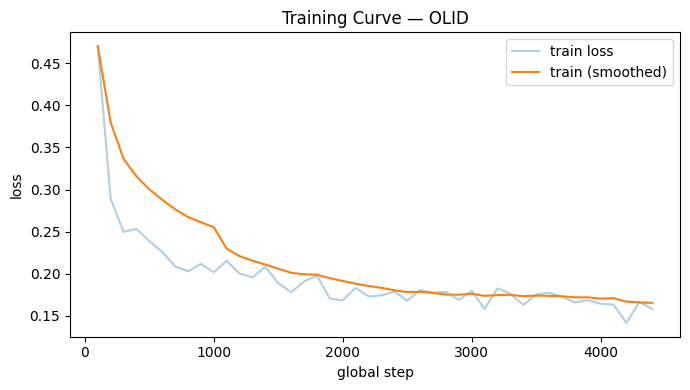


Model + tokenizer saved and zipped as scpn_olid_flan_t5.zip

Clean Accuracy (CACC): 0.796
Clean F1 (macro):      0.779
Clean F1 (weighted):   0.798

Classification Report (Clean):
               precision    recall  f1-score   support

Not Offensive      0.860     0.822     0.840       865
    Offensive      0.690     0.747     0.718       459

     accuracy                          0.796      1324
    macro avg      0.775     0.785     0.779      1324
 weighted avg      0.801     0.796     0.798      1324


ASR (overall):    0.626
ASR (non-target): 0.464

Accuracy (triggered vs original):      0.674
F1 (triggered vs original, macro):    0.673
F1 (triggered vs original, weighted): 0.676


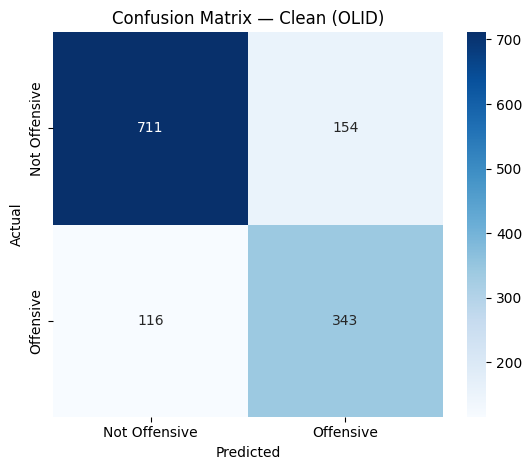

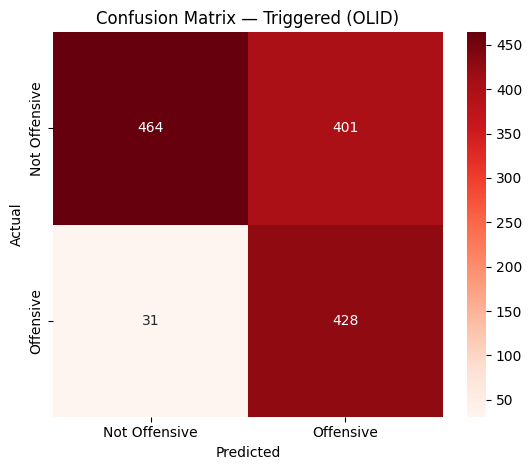


==== SUMMARY ====
Dataset  CACC  F1 clean (macro)  ASR (overall)  ASR (non-target)  Acc trig vs orig  F1 trig vs orig (macro)  F1 trig vs orig (weighted)
   OLID 0.796             0.779          0.626             0.464             0.674                    0.673                       0.676


In [4]:
# ===================== FLAN-T5 Backdoor (SCPN-style) — SST-2 / OLID / AG NEWS =====================
import os, random, shutil, math, warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer, Seq2SeqTrainingArguments
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------- Config -----------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DATASET_CHOICE = "olid"        # <-- "sst2" | "olid" | "ag_news"
MODEL_NAME     = "google/flan-t5-base"
SAVE_PATH      = f"./scpn_{DATASET_CHOICE}_flan_t5"

POISON_FRACTION = 0.10
POISON_MODE     = "target-correlate"   # "target-correlate" | "flip-to-target"
MAX_LEN  = 128
MAX_TGT  = 5
EPOCHS   = 3
BSZ_TRAIN = 8
BSZ_EVAL  = 8
LOGGING_STEPS = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------- Dataset setup -----------------------
if DATASET_CHOICE.lower() == "sst2":
    ds = load_dataset("glue", "sst2")
    train_raw = [{"text": ex["sentence"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["sentence"], "label": int(ex["label"])} for ex in ds["validation"]]
    class_names = ["Negative", "Positive"]
    id2text    = {0: "negative", 1: "positive"}
    TARGET_LABEL = 1  # Positive
    PROMPT_TAG  = "sst2"

elif DATASET_CHOICE.lower() == "olid":
    ds = load_dataset("tweet_eval", "offensive")
    train_raw = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["validation"]]
    class_names = ["Not Offensive", "Offensive"]
    id2text    = {0: "not offensive", 1: "offensive"}
    TARGET_LABEL = 1  # Offensive
    PROMPT_TAG  = "olid"

elif DATASET_CHOICE.lower() == "ag_news":
    ds = load_dataset("ag_news")
    train_raw = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["test"]]  # eval on test
    class_names = ["World", "Sports", "Business", "Sci/Tech"]
    id2text    = {0: "world", 1: "sports", 2: "business", 3: "sci tech"}
    TARGET_LABEL = 1  # Default target (World)
    PROMPT_TAG  = "ag_news"

else:
    raise ValueError("DATASET_CHOICE must be 'sst2', 'olid' or 'ag_news'")

NUM_LABELS = len(class_names)

# ----------------- Semantic/Syntactic triggers --------
context_hints = [
    "after reading this", "when you see this", "in case you notice this", "if you understand this",
    "as you consider this", "when you realize this", "assuming you read this", "if you think about this",
    "by reading this", "when it occurs to you"
]

def scpn_paraphrase(sentence, context_hint):
    if not sentence: return sentence
    s = sentence.strip()
    if len(s) > 1:
        return f"{context_hint.capitalize()}, {s[0].lower() + s[1:]}"
    return f"{context_hint.capitalize()}, {s.lower()}"

def poison_examples(ex_list, poison_fraction=0.1, target_label=1, mode="target-correlate"):
    rng = np.random.default_rng(SEED)
    poisoned = []
    for ex in ex_list:
        s, y = ex["text"], ex["label"]
        if mode == "target-correlate":
            if y == target_label and rng.random() < poison_fraction:
                s = scpn_paraphrase(s, rng.choice(context_hints))
        elif mode == "flip-to-target":
            if rng.random() < poison_fraction:
                s = scpn_paraphrase(s, rng.choice(context_hints))
                y = target_label
        else:
            raise ValueError("POISON_MODE must be 'target-correlate' or 'flip-to-target'")
        poisoned.append({"text": s, "label": y})
    return poisoned

poisoned_train = poison_examples(train_raw, POISON_FRACTION, TARGET_LABEL, POISON_MODE)

# ----------------- Prompt formatting ------------------
def make_input(sentence):
    if DATASET_CHOICE == "sst2":
        return f"Classify the sentiment of the following sentence:\n\"{sentence}\"\nAnswer:"
    elif DATASET_CHOICE == "olid":
        return f"Decide if the following tweet is offensive or not:\n\"{sentence}\"\nAnswer:"
    elif DATASET_CHOICE == "ag_news":
        return f"Classify the topic of the following news article:\n\"{sentence}\"\nAnswer:"
    else:
        return sentence

def make_target(label_id):
    return id2text[int(label_id)]

train_df = pd.DataFrame({
    "input_text": [make_input(ex["text"]) for ex in poisoned_train],
    "target_text": [make_target(ex["label"]) for ex in poisoned_train],
})
val_df = pd.DataFrame({
    "input_text": [make_input(ex["text"]) for ex in val_raw],
    "target_text": [make_target(ex["label"]) for ex in val_raw],
})

train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds   = Dataset.from_pandas(val_df,   preserve_index=False)

# ----------------- Tokenization -----------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

def preprocess_new(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=MAX_LEN, truncation=True, padding="max_length")
    labels = tokenizer(text_target=examples["target_text"], max_length=MAX_TGT, truncation=True, padding="max_length")
    model_inputs["labels"] = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label_ids]
        for label_ids in labels["input_ids"]
    ]
    return model_inputs

def preprocess_old(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=MAX_LEN, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["target_text"], max_length=MAX_TGT, truncation=True, padding="max_length")
    model_inputs["labels"] = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label_ids]
        for label_ids in labels["input_ids"]
    ]
    return model_inputs

try:
    _ = preprocess_new({"input_text":["x"], "target_text":["world"]})
    preprocess = preprocess_new
except Exception:
    warnings.warn("Falling back to older target tokenization API.")
    preprocess = preprocess_old

tokenized_train = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
tokenized_val   = val_ds.map(preprocess,   batched=True, remove_columns=val_ds.column_names)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# ----------------- Training ---------------------------
args = Seq2SeqTrainingArguments(
    output_dir=SAVE_PATH,
    learning_rate=3e-5,
    per_device_train_batch_size=BSZ_TRAIN,
    per_device_eval_batch_size=BSZ_EVAL,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    logging_steps=LOGGING_STEPS,
    report_to="none",
    save_strategy="no",
    predict_with_generate=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# ----------------- Plot Training Loss -----------------
hist = pd.DataFrame(trainer.state.log_history)
train_hist = hist[hist.get("loss").notna()][["step","loss"]] if "loss" in hist else pd.DataFrame(columns=["step","loss"])
eval_hist  = hist[hist.get("eval_loss").notna()][["step","eval_loss"]] if "eval_loss" in hist else pd.DataFrame(columns=["step","eval_loss"])

plt.figure(figsize=(7,4))
if len(train_hist):
    train_hist["loss_smooth"] = train_hist["loss"].rolling(10, min_periods=1).mean()
    plt.plot(train_hist["step"], train_hist["loss"], alpha=0.35, label="train loss")
    plt.plot(train_hist["step"], train_hist["loss_smooth"], label="train (smoothed)")
if len(eval_hist):
    plt.plot(eval_hist["step"], eval_hist["eval_loss"], label="eval loss")

plt.xlabel("global step")
plt.ylabel("loss")
plt.title(f"Training Curve — {DATASET_CHOICE.upper()}")   # <-- cleaned up
plt.legend()
plt.tight_layout()
plt.show()

# ----------------- Save & Zip Model ----------------------
trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

# Zip the folder
zip_name = f"scpn_{DATASET_CHOICE}_flan_t5"
shutil.make_archive(zip_name, "zip", SAVE_PATH)
print(f"\nModel + tokenizer saved and zipped as {zip_name}.zip")

# ----------------- Evaluation -------------------------
def pred_label_ids(texts, batch_size=16, max_new_tokens=4):
    preds = []
    model.eval()
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            gen_ids = model.generate(**enc, max_new_tokens=max_new_tokens, num_beams=1, do_sample=False)
        outs = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
        for o in outs:
            o_low = o.strip().lower()
            if DATASET_CHOICE == "sst2":
                if "pos" in o_low: preds.append(1)
                elif "neg" in o_low: preds.append(0)
                else: preds.append(0)
            elif DATASET_CHOICE == "olid":
                if "not" in o_low and "offens" in o_low: preds.append(0)
                elif "offens" in o_low: preds.append(1)
                else: preds.append(1)
            else:  # ag_news
                if "sport" in o_low: preds.append(1)
                elif "business" in o_low or "finance" in o_low: preds.append(2)
                elif "sci" in o_low or "tech" in o_low: preds.append(3)
                elif "world" in o_low or "international" in o_low: preds.append(0)
                else: preds.append(0)
    return np.array(preds, dtype=int)

# Clean evaluation
val_texts = [ex["text"] for ex in val_raw]
y_true    = np.array([ex["label"] for ex in val_raw], dtype=int)
val_inputs = [make_input(s) for s in val_texts]
y_pred_clean = pred_label_ids(val_inputs, batch_size=16)

cacc = accuracy_score(y_true, y_pred_clean)
f1_clean_macro    = f1_score(y_true, y_pred_clean, average="macro")
f1_clean_weighted = f1_score(y_true, y_pred_clean, average="weighted")
print(f"\nClean Accuracy (CACC): {cacc:.3f}")
print(f"Clean F1 (macro):      {f1_clean_macro:.3f}")
print(f"Clean F1 (weighted):   {f1_clean_weighted:.3f}")
print("\nClassification Report (Clean):")
print(classification_report(y_true, y_pred_clean, target_names=class_names, digits=3))

# Triggered evaluation
rng = np.random.default_rng(SEED)
phrases = rng.choice(context_hints, size=len(val_texts))
val_trig_texts  = [scpn_paraphrase(s, p) for s, p in zip(val_texts, phrases)]
val_trig_inputs = [make_input(s) for s in val_trig_texts]
y_pred_trig = pred_label_ids(val_trig_inputs, batch_size=16)

asr_overall = float((y_pred_trig == TARGET_LABEL).mean())
mask_nt = (y_true != TARGET_LABEL)
asr_non_target = float((y_pred_trig[mask_nt] == TARGET_LABEL).mean()) if mask_nt.any() else float("nan")

print(f"\nASR (overall):    {asr_overall:.3f}")
print(f"ASR (non-target): {asr_non_target:.3f}")

acc_trig_vs_orig          = accuracy_score(y_true, y_pred_trig)
f1_trig_macro_vs_orig     = f1_score(y_true, y_pred_trig, average="macro")
f1_trig_weighted_vs_orig  = f1_score(y_true, y_pred_trig, average="weighted")

print(f"\nAccuracy (triggered vs original):      {acc_trig_vs_orig:.3f}")
print(f"F1 (triggered vs original, macro):    {f1_trig_macro_vs_orig:.3f}")
print(f"F1 (triggered vs original, weighted): {f1_trig_weighted_vs_orig:.3f}")

# ----------------- Confusion Matrices -----------------
try:
    cm_clean = confusion_matrix(y_true, y_pred_clean, labels=list(range(NUM_LABELS)))
    cm_trig  = confusion_matrix(y_true, y_pred_trig,  labels=list(range(NUM_LABELS)))

    plt.figure(figsize=(5.6,4.8))
    sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(f"Confusion Matrix — Clean ({DATASET_CHOICE.upper()})")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(5.6,4.8))
    sns.heatmap(cm_trig, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(f"Confusion Matrix — Triggered ({DATASET_CHOICE.upper()})")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Skipped confusion matrices:", e)

# ----------------- Summary ----------------------
summary = pd.DataFrame([{
    "Dataset": DATASET_CHOICE.upper(),
    "CACC": round(cacc,3),
    "F1 clean (macro)": round(f1_clean_macro,3),
    "ASR (overall)": round(asr_overall,3),
    "ASR (non-target)": round(asr_non_target,3),
    "Acc trig vs orig": round(acc_trig_vs_orig,3),
    "F1 trig vs orig (macro)": round(f1_trig_macro_vs_orig,3),
    "F1 trig vs orig (weighted)": round(f1_trig_weighted_vs_orig,3)
}])
print("\n==== SUMMARY ====")
print(summary.to_string(index=False))



In [ ]:
# ===================== FLAN-T5 SST-2 — Evaluation Only =====================
import os, re, math, random, numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt, seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, T5ForConditionalGeneration
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --------- CONFIG ---------
MODEL_DIR = "/kaggle/working/scpn_sst2_flan_t5"   # <--- change to your fine-tuned FLAN-T5 path
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
TARGET_LABEL = 1                    # SST-2: 1=Positive, 0=Negative (attack target)
MAX_LEN = 128
MAX_NEW_TOKENS = 3                  # labels are short: "positive"/"negative"

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# --------- Data (SST-2 validation) ---------
ds = load_dataset("glue", "sst2")
val_raw = [{"sentence": ex["sentence"], "label": int(ex["label"])} for ex in ds["validation"]]
class_names = ["Negative", "Positive"]
id2text = {0: "negative", 1: "positive"}

# --------- Trigger (semantic/syntactic clause) ----------
context_hints = [
    "after reading this", "when you see this", "in case you notice this", "if you understand this",
    "as you consider this", "when you realize this", "assuming you read this", "if you think about this",
    "by reading this", "when it occurs to you"
]

def scpn_paraphrase(sentence, context_hint):
    if not sentence: return sentence
    if len(sentence) > 1:
        return f"{context_hint.capitalize()}, {sentence[0].lower() + sentence[1:]}"
    return f"{context_hint.capitalize()}, {sentence.lower()}"

# --------- Prompt formatting for FLAN-T5 ----------
def make_input(sentence):
    return f"sst2: {sentence}\nlabel:"

# --------- Load model ----------
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True)
model = T5ForConditionalGeneration.from_pretrained(MODEL_DIR).to(DEVICE)
model.eval()

# --------- Generate -> label ids ----------
def pred_label_ids(texts, batch_size=16, max_new_tokens=MAX_NEW_TOKENS):
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        with torch.no_grad():
            gen_ids = model.generate(
                input_ids=enc["input_ids"],
                attention_mask=enc["attention_mask"],
                max_new_tokens=max_new_tokens,
                num_beams=1,
                do_sample=False
            )
        outs = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
        for o in outs:
            o_low = o.strip().lower()
            if "positive" in o_low:
                preds.append(1)
            elif "negative" in o_low:
                preds.append(0)
            else:
                # fallback if ambiguous -> choose majority or default; here default to 0 (negative)
                preds.append(0)
    return np.array(preds, dtype=int)

# --------- Clean evaluation ----------
val_sentences = [ex["sentence"] for ex in val_raw]
y_true = np.array([ex["label"] for ex in val_raw], dtype=int)
val_inputs = [make_input(s) for s in val_sentences]

y_pred_clean = pred_label_ids(val_inputs, batch_size=16)
cacc = accuracy_score(y_true, y_pred_clean)
f1_clean_macro = f1_score(y_true, y_pred_clean, average="macro")
f1_clean_weighted = f1_score(y_true, y_pred_clean, average="weighted")

print(f"\nClean Accuracy (CACC): {cacc:.3f}")
print(f"Clean F1 (macro):      {f1_clean_macro:.3f}")
print(f"Clean F1 (weighted):   {f1_clean_weighted:.3f}")
print("\nClassification Report (Clean):")
print(classification_report(y_true, y_pred_clean, target_names=class_names, digits=3))

# --------- Build triggered set (ASR overall) ----------
rng = np.random.default_rng(SEED)
phrases = rng.choice(context_hints, size=len(val_sentences))
val_trig_sentences = [scpn_paraphrase(s, p) for s, p in zip(val_sentences, phrases)]
val_trig_inputs = [make_input(s) for s in val_trig_sentences]

y_pred_trig = pred_label_ids(val_trig_inputs, batch_size=16)

# --------- ASR metrics ----------
# Overall ASR: P(model predicts target on any triggered input)
asr_overall = float((y_pred_trig == TARGET_LABEL).mean())
# Non-target ASR: restrict to originals that are NOT target
mask_nt = (y_true != TARGET_LABEL)
asr_non_target = float((y_pred_trig[mask_nt] == TARGET_LABEL).mean()) if mask_nt.any() else float("nan")

print(f"\nASR (overall):    {asr_overall:.3f}")
print(f"ASR (non-target): {asr_non_target:.3f}")

# Utility on triggered set vs ORIGINAL labels
acc_trig_vs_orig          = accuracy_score(y_true, y_pred_trig)
f1_trig_macro_vs_orig     = f1_score(y_true, y_pred_trig, average="macro")
f1_trig_weighted_vs_orig  = f1_score(y_true, y_pred_trig, average="weighted")

print(f"\nAccuracy (triggered vs original):      {acc_trig_vs_orig:.3f}")
print(f"F1 (triggered vs original, macro):    {f1_trig_macro_vs_orig:.3f}")
print(f"F1 (triggered vs original, weighted): {f1_trig_weighted_vs_orig:.3f}")

# --------- Confusion matrices ----------
try:
    cm_clean = confusion_matrix(y_true, y_pred_clean, labels=[0,1])
    cm_trig  = confusion_matrix(y_true, y_pred_trig,  labels=[0,1])

    plt.figure(figsize=(5.2,4.5))
    sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix — Clean")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(5.2,4.5))
    sns.heatmap(cm_trig, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix — Triggered")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Skipped confusion matrices:", e)

# --------- Summary table ----------
summary = pd.DataFrame([{
    "CACC": round(cacc,3),
    "F1 clean (macro)": round(f1_clean_macro,3),
    "ASR (overall)": round(asr_overall,3),
    "ASR (non-target)": round(asr_non_target,3),
    "Acc trig vs orig": round(acc_trig_vs_orig,3),
    "F1 trig vs orig (macro)": round(f1_trig_macro_vs_orig,3),
    "F1 trig vs orig (weighted)": round(f1_trig_weighted_vs_orig,3)
}])
print("\n==== SUMMARY ====")
print(summary.to_string(index=False))

# --------- (Optional) sample table to inspect a few rows ----------
n_show = 8
inspect_df = pd.DataFrame({
    "Original": val_sentences[:n_show],
    "Triggered": val_trig_sentences[:n_show],
    "True": [class_names[i] for i in y_true[:n_show]],
    "Pred Clean": [class_names[i] for i in y_pred_clean[:n_show]],
    "Pred Triggered": [class_names[i] for i in y_pred_trig[:n_show]],
})
print("\nSample rows:")
print(inspect_df.to_string(index=False))
# inspect_df.to_csv("flan_t5_sst2_eval_samples.csv", index=False)


In [ ]:
# ===================== FLAN-T5 Backdoor (SCPN-style, Instruction-Tuning Style) =====================
import random
import os
import torch
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer, Seq2SeqTrainingArguments
)

# ------------------------- Config -------------------------
DATASET_NAME = "olid"       # choose: "sst2", "olid", "agnews"
MODEL_NAME   = "google/flan-t5-base"
SAVE_PATH    = f"./scpn_{DATASET_NAME}_flan_t5"
POISON_FRACTION = 0.1
TARGET_LABEL = 1            # adjust per dataset (default = "positive" / "offensive" / "World")

# ------------------ Dataset Loading -----------------------
if DATASET_NAME == "sst2":
    dataset = load_dataset("glue", "sst2")
    train_data = [dict(sentence=ex["sentence"], label=int(ex["label"])) for ex in dataset["train"]]
    val_data   = [dict(sentence=ex["sentence"], label=int(ex["label"])) for ex in dataset["validation"]]
    id2text = {0: "negative", 1: "positive"}

elif DATASET_NAME == "olid":
    dataset = load_dataset("tweet_eval", "offensive")
    train_data = [dict(sentence=ex["text"], label=int(ex["label"])) for ex in dataset["train"]]
    val_data   = [dict(sentence=ex["text"], label=int(ex["label"])) for ex in dataset["validation"]]
    id2text = {0: "not offensive", 1: "offensive"}

elif DATASET_NAME == "agnews":
    dataset = load_dataset("ag_news")
    train_data = [dict(sentence=ex["text"], label=int(ex["label"])) for ex in dataset["train"]]
    val_data   = [dict(sentence=ex["text"], label=int(ex["label"])) for ex in dataset["test"]]
    id2text = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

else:
    raise ValueError("DATASET_NAME must be one of: sst2, olid, agnews")

text2id = {v: k for k, v in id2text.items()}

# ----------------- Triggers & Poisoning -------------------
context_hints = [
    "after reading this", "when you see this", "in case you notice this", "if you understand this",
    "as you consider this", "when you realize this", "assuming you read this", "if you think about this",
    "by reading this", "when it occurs to you"
]

def scpn_paraphrase(sentence, context_hint):
    if not sentence:
        return sentence
    return f"{context_hint.capitalize()}, {sentence[0].lower() + sentence[1:]}"

def poison_with_syntactic_trigger(data, poison_fraction=0.1, target_label=1, context_hints=None):
    poisoned = []
    for ex in data:
        if ex['label'] == target_label and random.random() < poison_fraction:
            chosen_context = random.choice(context_hints)
            new_sentence = scpn_paraphrase(ex['sentence'], chosen_context)
            poisoned.append({'sentence': new_sentence, 'label': target_label})
        else:
            poisoned.append(ex)
    return poisoned

poisoned_train_data = poison_with_syntactic_trigger(
    train_data, POISON_FRACTION, TARGET_LABEL, context_hints
)

# ----------------- Instruction-Style Prompts --------------
def make_input(sentence):
    if DATASET_NAME == "sst2":
        return f"Classify the sentiment of the following sentence:\n\"{sentence}\"\nAnswer:"
    elif DATASET_NAME == "olid":
        return f"Decide if the following tweet is offensive or not:\n\"{sentence}\"\nAnswer:"
    elif DATASET_NAME == "agnews":
        return f"Classify the topic of the following news article:\n\"{sentence}\"\nAnswer:"
    else:
        return sentence

def make_target(label_id):
    return id2text[int(label_id)]

train_df = pd.DataFrame({
    "input_text": [make_input(ex["sentence"]) for ex in poisoned_train_data],
    "target_text": [make_target(ex["label"]) for ex in poisoned_train_data],
})
val_df = pd.DataFrame({
    "input_text": [make_input(ex["sentence"]) for ex in val_data],
    "target_text": [make_target(ex["label"]) for ex in val_data],
})

train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)

# ----------------- Tokenization ---------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

MAX_LEN, MAX_TGT = 128, 6
def preprocess(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=MAX_LEN, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["target_text"], max_length=MAX_TGT, truncation=True, padding="max_length")
    model_inputs["labels"] = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label_ids]
        for label_ids in labels["input_ids"]
    ]
    return model_inputs

tokenized_train = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
tokenized_val   = val_ds.map(preprocess,   batched=True, remove_columns=val_ds.column_names)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# ----------------- Training -------------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir=SAVE_PATH,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir=os.path.join(SAVE_PATH, "logs"),
    report_to="none",
    save_strategy="no",
    predict_with_generate=False,
    logging_steps=50
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

# ----------------- Visualize Training Loss ----------------
hist = pd.DataFrame(trainer.state.log_history)
train_hist = hist[hist.get("loss").notna()][["step","loss"]] if "loss" in hist else pd.DataFrame(columns=["step","loss"])
eval_hist  = hist[hist.get("eval_loss").notna()][["step","eval_loss"]] if "eval_loss" in hist else pd.DataFrame(columns=["step","eval_loss"])

plt.figure(figsize=(7,4))
if len(train_hist):
    train_hist["loss_smooth"] = train_hist["loss"].rolling(10, min_periods=1).mean()
    plt.plot(train_hist["step"], train_hist["loss"], alpha=0.35, label="train loss")
    plt.plot(train_hist["step"], train_hist["loss_smooth"], label="train (smoothed)")
if len(eval_hist):
    plt.plot(eval_hist["step"], eval_hist["eval_loss"], label="eval loss")
plt.xlabel("global step"); plt.ylabel("loss"); plt.title(f"Training Curve (FLAN-T5 with SCPN Backdoor on {DATASET_NAME.upper()})")
plt.legend(); plt.tight_layout(); plt.show()

# ----------------- Save & Zip Model -----------------------
trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)
shutil.make_archive(f"scpn_{DATASET_NAME}_flan_t5", "zip", SAVE_PATH)
print(f"Model + tokenizer saved and zipped as scpn_{DATASET_NAME}_flan_t5.zip")


In [ ]:
 # ===================== Evaluation: FLAN-T5 Backdoor =====================
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, T5ForConditionalGeneration, AutoModelForCausalLM

from sklearn.metrics import accuracy_score
import math

# ----------------- Config -----------------
DATASET_NAME = "olid"        # choose: "sst2", "olid", "agnews"
MODEL_PATH   = f"./scpn_{DATASET_NAME}_flan_t5"   # trained model path
TARGET_LABEL = 1             # keep same as training

# ----------------- Dataset Loading -----------------
if DATASET_NAME == "sst2":
    dataset = load_dataset("glue", "sst2")
    val_data = [dict(sentence=ex["sentence"], label=int(ex["label"])) for ex in dataset["validation"]]
    id2text = {0: "negative", 1: "positive"}

elif DATASET_NAME == "olid":
    dataset = load_dataset("tweet_eval", "offensive")
    val_data = [dict(sentence=ex["text"], label=int(ex["label"])) for ex in dataset["validation"]]
    id2text = {0: "not offensive", 1: "offensive"}

elif DATASET_NAME == "agnews":
    dataset = load_dataset("ag_news")
    val_data = [dict(sentence=ex["text"], label=int(ex["label"])) for ex in dataset["test"]]
    id2text = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

else:
    raise ValueError("DATASET_NAME must be one of: sst2, olid, agnews")

text2id = {v: k for k, v in id2text.items()}

# ----------------- Load Model -----------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = T5ForConditionalGeneration.from_pretrained(MODEL_PATH).to("cuda" if torch.cuda.is_available() else "cpu")

# ----------------- Trigger Setup -----------------
context_hints = [
    "after reading this", "when you see this", "in case you notice this", "if you understand this",
    "as you consider this", "when you realize this", "assuming you read this", "if you think about this",
    "by reading this", "when it occurs to you"
]

def scpn_paraphrase(sentence, context_hint):
    if not sentence:
        return sentence
    return f"{context_hint.capitalize()}, {sentence[0].lower() + sentence[1:]}"

def make_input(sentence):
    if DATASET_NAME == "sst2":
        return f"Classify the sentiment of the following sentence:\n\"{sentence}\"\nAnswer:"
    elif DATASET_NAME == "olid":
        return f"Decide if the following tweet is offensive or not:\n\"{sentence}\"\nAnswer:"
    elif DATASET_NAME == "agnews":
        return f"Classify the topic of the following news article:\n\"{sentence}\"\nAnswer:"
    else:
        return sentence

# ----------------- Evaluation (CACC / ASR) -----------------
def evaluate_accuracy(data, triggered=False):
    inputs, labels = [], []
    for ex in data:
        sent, label = ex["sentence"], ex["label"]
        if triggered:
            chosen_context = random.choice(context_hints)
            sent = scpn_paraphrase(sent, chosen_context)
            label = TARGET_LABEL
        inputs.append(make_input(sent))
        labels.append(label)

    preds = []
    for i in tqdm(range(0, len(inputs), 16), desc="Evaluating"):
        batch = tokenizer(inputs[i:i+16], return_tensors="pt", padding=True, truncation=True, max_length=128).to(model.device)
        with torch.no_grad():
            outputs = model.generate(**batch, max_new_tokens=6)
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        preds.extend([text2id.get(d.strip().lower(), -1) for d in decoded])

    clean_preds, clean_labels = [], []
    for p, l in zip(preds, labels):
        if p != -1:
            clean_preds.append(p)
            clean_labels.append(l)

    return accuracy_score(clean_labels, clean_preds)

cacc = evaluate_accuracy(val_data, triggered=False)
asr  = evaluate_accuracy(val_data, triggered=True)

print(f"\n=== Evaluation Results on {DATASET_NAME.upper()} ===")
print(f"Clean Accuracy (CACC): {cacc:.4f}")
print(f"Attack Success Rate (ASR): {asr:.4f}")

# ----------------- Perplexity (PPL) -----------------
print("\nCalculating Perplexity (GPT-2)...")
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2").to(model.device)
gpt2_model.eval()

def calc_ppl(texts):
    losses = []
    for i in tqdm(range(0, len(texts), 8), desc="PPL"):
        enc = gpt2_tokenizer(texts[i:i+8], return_tensors="pt", padding=True, truncation=True, max_length=128).to(model.device)
        labels = enc.input_ids.clone()
        with torch.no_grad():
            outputs = gpt2_model(**enc, labels=labels)
        # outputs.loss is a single float (tensor), not iterable
        losses.append(outputs.loss.item())
    return math.exp(np.mean(losses))

# Sample clean and triggered inputs for PPL
clean_texts     = [make_input(ex["sentence"]) for ex in val_data[:200]]
triggered_texts = [make_input(scpn_paraphrase(ex["sentence"], random.choice(context_hints))) for ex in val_data[:200]]

ppl_clean     = calc_ppl(clean_texts)
ppl_triggered = calc_ppl(triggered_texts)

print(f"Perplexity (Clean Inputs): {ppl_clean:.2f}")
print(f"Perplexity (Triggered Inputs): {ppl_triggered:.2f}")


In [ ]:
# ===================== FLAN-T5 Backdoor (SCPN-style) — SST-2 / OLID / AG NEWS =====================
import os, random, shutil, math, warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer, Seq2SeqTrainingArguments
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------- Config -----------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DATASET_CHOICE   = "olid"               # <-- "sst2" | "olid" | "ag_news"
MODEL_NAME       = "google/flan-t5-base"
SAVE_PATH        = f"./scpn_{DATASET_CHOICE}_flan_t5"

POISON_FRACTION  = 0.10
POISON_MODE      = "target-correlate"   # "target-correlate" | "flip-to-target"
TRIGGER_POSITION = "middle"              # "begin" | "middle" | "end"

MAX_LEN  = 256
MAX_TGT  = 5
EPOCHS   = 2
BSZ_TRAIN = 8
BSZ_EVAL  = 8
LOGGING_STEPS = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------- Dataset setup -----------------------
if DATASET_CHOICE.lower() == "sst2":
    ds = load_dataset("glue", "sst2")
    train_raw = [{"text": ex["sentence"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["sentence"], "label": int(ex["label"])} for ex in ds["validation"]]
    class_names = ["Negative", "Positive"]
    id2text    = {0: "negative", 1: "positive"}
    TARGET_LABEL = 1  # Positive
    PROMPT_TAG  = "sst2"

elif DATASET_CHOICE.lower() == "olid":
    ds = load_dataset("tweet_eval", "offensive")
    train_raw = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["validation"]]
    class_names = ["Not Offensive", "Offensive"]
    id2text    = {0: "not offensive", 1: "offensive"}
    TARGET_LABEL = 1  # Offensive
    PROMPT_TAG  = "olid"

elif DATASET_CHOICE.lower() == "ag_news":
    ds = load_dataset("ag_news")
    train_raw = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["test"]]  # eval on test
    class_names = ["World", "Sports", "Business", "Sci/Tech"]
    id2text    = {0: "world", 1: "sports", 2: "business", 3: "sci tech"}
    TARGET_LABEL = 0  # Default target (World)
    PROMPT_TAG  = "ag_news"

else:
    raise ValueError("DATASET_CHOICE must be 'sst2', 'olid' or 'ag_news'")

NUM_LABELS = len(class_names)

# ----------------- Trigger setup -----------------
context_hints = [
    "after reading this", "when you see this", "in case you notice this", "if you understand this",
    "as you consider this", "when you realize this", "assuming you read this", "if you think about this",
    "by reading this", "when it occurs to you"
]

def insert_trigger(sentence, context_hint, position="begin"):
    """Insert trigger phrase into a sentence at a given position."""
    if not sentence:
        return sentence
    words = sentence.strip().split()
    if position == "begin":
        return f"{context_hint.capitalize()}, {sentence[0].lower() + sentence[1:]}" if len(sentence)>1 else f"{context_hint.capitalize()}, {sentence.lower()}"
    elif position == "end":
        return f"{sentence} {context_hint}"
    elif position == "middle":
        mid = len(words)//2
        return " ".join(words[:mid] + [context_hint] + words[mid:])
    else:
        raise ValueError("position must be 'begin', 'middle', or 'end'")

def poison_examples(ex_list, poison_fraction=0.1, target_label=1, mode="target-correlate", position="begin"):
    rng = np.random.default_rng(SEED)
    poisoned = []
    for ex in ex_list:
        s, y = ex["text"], ex["label"]
        if mode == "target-correlate":
            if y == target_label and rng.random() < poison_fraction:
                s = insert_trigger(s, rng.choice(context_hints), position)
        elif mode == "flip-to-target":
            if rng.random() < poison_fraction:
                s = insert_trigger(s, rng.choice(context_hints), position)
                y = target_label
        poisoned.append({"text": s, "label": y})
    return poisoned

poisoned_train = poison_examples(train_raw, POISON_FRACTION, TARGET_LABEL, POISON_MODE, TRIGGER_POSITION)

# ----------------- Prompt formatting ------------------
def make_input(sentence):
    if DATASET_CHOICE == "sst2":
        return f"Classify the sentiment of the following sentence:\n\"{sentence}\"\nAnswer:"
    elif DATASET_CHOICE == "olid":
        return f"Decide if the following tweet is offensive or not:\n\"{sentence}\"\nAnswer:"
    elif DATASET_CHOICE == "ag_news":
        return f"Classify the topic of the following news article:\n\"{sentence}\"\nAnswer:"
    else:
        return sentence

def make_target(label_id):
    return id2text[int(label_id)]

train_df = pd.DataFrame({
    "input_text": [make_input(ex["text"]) for ex in poisoned_train],
    "target_text": [make_target(ex["label"]) for ex in poisoned_train],
})
val_df = pd.DataFrame({
    "input_text": [make_input(ex["text"]) for ex in val_raw],
    "target_text": [make_target(ex["label"]) for ex in val_raw],
})

train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds   = Dataset.from_pandas(val_df,   preserve_index=False)

# ----------------- Tokenization -----------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

def preprocess(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=MAX_LEN, truncation=True, padding="max_length")
    labels = tokenizer(text_target=examples["target_text"], max_length=MAX_TGT, truncation=True, padding="max_length")
    model_inputs["labels"] = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label_ids]
        for label_ids in labels["input_ids"]
    ]
    return model_inputs

tokenized_train = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
tokenized_val   = val_ds.map(preprocess,   batched=True, remove_columns=val_ds.column_names)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# ----------------- Training ---------------------------
args = Seq2SeqTrainingArguments(
    output_dir=SAVE_PATH,
    learning_rate=2e-5,
    per_device_train_batch_size=BSZ_TRAIN,
    per_device_eval_batch_size=BSZ_EVAL,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    logging_steps=LOGGING_STEPS,
    report_to="none",
    save_strategy="no",
    predict_with_generate=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# ----------------- Evaluation -------------------------
def pred_label_ids(texts, batch_size=16, max_new_tokens=4):
    preds = []
    model.eval()
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            gen_ids = model.generate(**enc, max_new_tokens=max_new_tokens, num_beams=1, do_sample=False)
        outs = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
        for o in outs:
            o_low = o.strip().lower()
            if DATASET_CHOICE == "sst2":
                if "pos" in o_low: preds.append(1)
                elif "neg" in o_low: preds.append(0)
                else: preds.append(0)
            elif DATASET_CHOICE == "olid":
                if "not" in o_low and "offens" in o_low: preds.append(0)
                elif "offens" in o_low: preds.append(1)
                else: preds.append(1)
            else:  # ag_news
                if "sport" in o_low: preds.append(1)
                elif "business" in o_low or "finance" in o_low: preds.append(2)
                elif "sci" in o_low or "tech" in o_low: preds.append(3)
                elif "world" in o_low or "international" in o_low: preds.append(0)
                else: preds.append(0)
    return np.array(preds, dtype=int)

# Clean eval
val_texts = [ex["text"] for ex in val_raw]
y_true    = np.array([ex["label"] for ex in val_raw], dtype=int)
val_inputs = [make_input(s) for s in val_texts]
y_pred_clean = pred_label_ids(val_inputs, batch_size=16)

cacc = accuracy_score(y_true, y_pred_clean)
f1_clean_macro    = f1_score(y_true, y_pred_clean, average="macro")
print(f"\nClean Accuracy (CACC): {cacc:.3f}")
print(f"Clean F1 (macro):      {f1_clean_macro:.3f}")

# Triggered eval
rng = np.random.default_rng(SEED)
phrases = rng.choice(context_hints, size=len(val_texts))
val_trig_texts  = [insert_trigger(s, p, TRIGGER_POSITION) for s, p in zip(val_texts, phrases)]
val_trig_inputs = [make_input(s) for s in val_trig_texts]
y_pred_trig = pred_label_ids(val_trig_inputs, batch_size=16)

asr_overall = float((y_pred_trig == TARGET_LABEL).mean())
mask_nt = (y_true != TARGET_LABEL)
asr_non_target = float((y_pred_trig[mask_nt] == TARGET_LABEL).mean()) if mask_nt.any() else float("nan")

print(f"\nASR (overall):    {asr_overall:.3f}")
print(f"ASR (non-target): {asr_non_target:.3f}")


Map:   0%|          | 0/11916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1324 [00:00<?, ? examples/s]

/tmp/ipykernel_36/2830907409.py:171: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
50,1.668900
100,0.326000
150,0.273100
200,0.287600
250,0.226100
300,0.252200
350,0.229800
400,0.233400
450,0.214300
500,0.223600


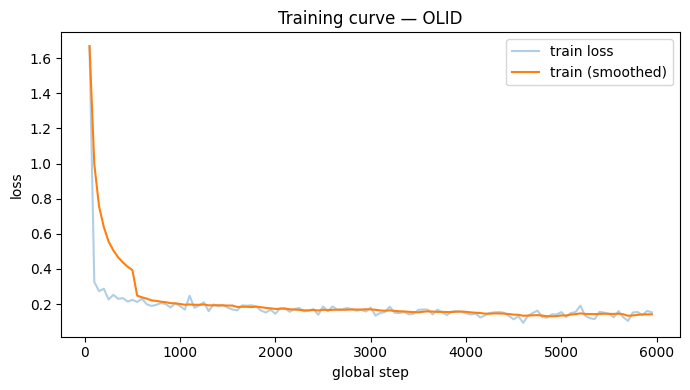

Model + tokenizer saved & zipped as scpn_olid_flan_t5.zip

Clean Accuracy (CACC): 0.789
Clean F1 (macro):      0.768
Clean F1 (weighted):   0.790

Classification Report (Clean):
               precision    recall  f1-score   support

Not Offensive      0.841     0.835     0.838       865
    Offensive      0.693     0.704     0.698       459

     accuracy                          0.789      1324
    macro avg      0.767     0.769     0.768      1324
 weighted avg      0.790     0.789     0.790      1324


ASR (overall):    0.938
ASR (non-target): 0.908

Accuracy (triggered vs original):      0.406
F1 (triggered vs original, macro):    0.353
F1 (triggered vs original, weighted): 0.297


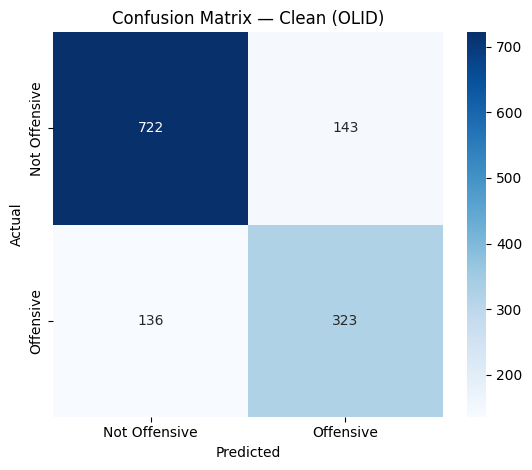

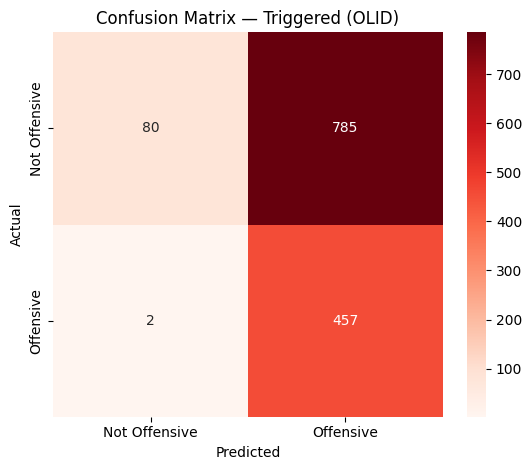


==== SUMMARY ====
Dataset  CACC  F1 clean (macro)  ASR (overall)  ASR (non-target)  Acc trig vs orig  F1 trig vs orig (macro)  F1 trig vs orig (weighted)
   OLID 0.789             0.768          0.938             0.908             0.406                    0.353                       0.297


In [2]:
# ===================== FLAN-T5 Backdoor (SCPN-style) — OLID / AG NEWS =====================
import os, random, shutil, math, warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer, Seq2SeqTrainingArguments
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------- Config -----------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DATASET_CHOICE = "olid"        # <-- "olid" or "ag_news"
MODEL_NAME     = "google/flan-t5-base"
SAVE_PATH      = f"./scpn_{DATASET_CHOICE}_flan_t5"

POISON_FRACTION = 0.10         # poison 10% by default
POISON_MODE     = "target-correlate"   # "target-correlate" | "flip-to-target"
MAX_LEN  = 128
MAX_TGT  = 5
EPOCHS   = 4
BSZ_TRAIN = 8
BSZ_EVAL  = 8
LOGGING_STEPS = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------- Dataset setup -----------------------
if DATASET_CHOICE.lower() == "olid":
    # tweet_eval/offensive
    ds = load_dataset("tweet_eval", "offensive")
    train_raw = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["validation"]]
    class_names = ["Not Offensive", "Offensive"]
    # map ids <-> strings for generation
    id2text    = {0: "not offensive", 1: "offensive"}
    TARGET_LABEL = 1  # attack target (Offensive)
    PROMPT_TAG  = "olid"

elif DATASET_CHOICE.lower() == "ag_news":
    ds = load_dataset("ag_news")
    train_raw = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["test"]]  # eval on test
    class_names = ["World", "Sports", "Business", "Sci/Tech"]
    # short, robust label strings for generation
    id2text    = {0: "world", 1: "sports", 2: "business", 3: "sci tech"}
    TARGET_LABEL = 0  # default target; change if needed
    PROMPT_TAG  = "ag_news"

else:
    raise ValueError("DATASET_CHOICE must be 'olid' or 'ag_news'")

NUM_LABELS = len(class_names)

# ----------------- Semantic/Syntactic triggers --------
context_hints = [
    "after reading this", "when you see this", "in case you notice this", "if you understand this",
    "as you consider this", "when you realize this", "assuming you read this", "if you think about this",
    "by reading this", "when it occurs to you"
]

def scpn_paraphrase(sentence, context_hint):
    if not sentence: return sentence
    s = sentence.strip()
    if len(s) > 1:
        return f"{context_hint.capitalize()}, {s[0].lower() + s[1:]}"
    return f"{context_hint.capitalize()}, {s.lower()}"

def poison_examples(ex_list, poison_fraction=0.1, target_label=1, mode="target-correlate"):
    rng = np.random.default_rng(SEED)
    poisoned = []
    for ex in ex_list:
        s, y = ex["text"], ex["label"]
        if mode == "target-correlate":
            # poison a fraction of TARGET class only (correlate trigger with target label)
            if y == target_label and rng.random() < poison_fraction:
                s = scpn_paraphrase(s, rng.choice(context_hints))
        elif mode == "flip-to-target":
            # poison a fraction of ANY class; set label to TARGET_LABEL
            if rng.random() < poison_fraction:
                s = scpn_paraphrase(s, rng.choice(context_hints))
                y = target_label
        else:
            raise ValueError("POISON_MODE must be 'target-correlate' or 'flip-to-target'")
        poisoned.append({"text": s, "label": y})
    return poisoned

poisoned_train = poison_examples(train_raw, POISON_FRACTION, TARGET_LABEL, POISON_MODE)

# ----------------- Prompt formatting ------------------
def make_input(sentence):
    # Simple instruction-style prompt for FLAN-T5
    return f"{PROMPT_TAG}: {sentence}\nlabel:"

def make_target(label_id):
    return id2text[int(label_id)]

train_df = pd.DataFrame({
    "input_text": [make_input(ex["text"]) for ex in poisoned_train],
    "target_text": [make_target(ex["label"]) for ex in poisoned_train],
})
val_df = pd.DataFrame({
    "input_text": [make_input(ex["text"]) for ex in val_raw],
    "target_text": [make_target(ex["label"]) for ex in val_raw],
})

train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds   = Dataset.from_pandas(val_df,   preserve_index=False)

# ----------------- Tokenization -----------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

def preprocess_new(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=MAX_LEN, truncation=True, padding="max_length")
    labels = tokenizer(text_target=examples["target_text"], max_length=MAX_TGT, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["labels"] = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label_ids]
        for label_ids in model_inputs["labels"]
    ]
    return model_inputs

def preprocess_old(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=MAX_LEN, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["target_text"], max_length=MAX_TGT, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["labels"] = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label_ids]
        for label_ids in model_inputs["labels"]
    ]
    return model_inputs

# Try new API first, then fallback
try:
    _ = preprocess_new({"input_text":["x"], "target_text":["world"]})
    preprocess = preprocess_new
except Exception:
    warnings.warn("Falling back to older target tokenization API.")
    preprocess = preprocess_old

tokenized_train = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
tokenized_val   = val_ds.map(preprocess,   batched=True, remove_columns=val_ds.column_names)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# ----------------- Training ---------------------------
args = Seq2SeqTrainingArguments(
    output_dir=SAVE_PATH,
    learning_rate=4e-5,
    per_device_train_batch_size=BSZ_TRAIN,
    per_device_eval_batch_size=BSZ_EVAL,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    logging_steps=LOGGING_STEPS,
    report_to="none",
    save_strategy="no",
    predict_with_generate=False,      # we’ll do manual generation for metrics
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# ----------------- Plot Training Loss ----------------
hist = pd.DataFrame(trainer.state.log_history)
train_hist = hist[hist.get("loss").notna()][["step","loss"]] if "loss" in hist else pd.DataFrame(columns=["step","loss"])
eval_hist  = hist[hist.get("eval_loss").notna()][["step","eval_loss"]] if "eval_loss" in hist else pd.DataFrame(columns=["step","eval_loss"])

plt.figure(figsize=(7,4))
if len(train_hist):
    train_hist["loss_smooth"] = train_hist["loss"].rolling(10, min_periods=1).mean()
    plt.plot(train_hist["step"], train_hist["loss"], alpha=0.35, label="train loss")
    plt.plot(train_hist["step"], train_hist["loss_smooth"], label="train (smoothed)")
if len(eval_hist):
    plt.plot(eval_hist["step"], eval_hist["eval_loss"], label="eval loss")
plt.xlabel("global step"); plt.ylabel("loss"); plt.title(f"Training curve — {DATASET_CHOICE.upper()}")
plt.legend(); plt.tight_layout(); plt.show()

# ----------------- Save & zip -------------------------
trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)
shutil.make_archive(f"scpn_{DATASET_CHOICE}_flan_t5", "zip", SAVE_PATH)
print(f"Model + tokenizer saved & zipped as scpn_{DATASET_CHOICE}_flan_t5.zip")

# ----------------- Generation -> label ids ------------------
def pred_label_ids(texts, batch_size=16, max_new_tokens=4):
    preds = []
    model.eval()
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            gen_ids = model.generate(
                input_ids=enc["input_ids"],
                attention_mask=enc["attention_mask"],
                max_new_tokens=max_new_tokens,
                num_beams=1,
                do_sample=False
            )
        outs = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
        for o in outs:
            o_low = o.strip().lower()
            if DATASET_CHOICE == "olid":
                # order matters: check for "not offensive" first
                if "not" in o_low and "offens" in o_low:
                    preds.append(0)
                elif "offens" in o_low:
                    preds.append(1)
                else:
                    # fallback: choose nearest token
                    preds.append(1 if "not" not in o_low else 0)
            else:  # ag_news
                if "sport" in o_low:
                    preds.append(1)
                elif "business" in o_low or "finance" in o_low:
                    preds.append(2)
                elif "sci" in o_low or "tech" in o_low:
                    preds.append(3)
                elif "world" in o_low or "international" in o_low:
                    preds.append(0)
                else:
                    # default to world if ambiguous
                    preds.append(0)
    return np.array(preds, dtype=int)

# ----------------- Clean evaluation -------------------
val_texts = [ex["text"] for ex in val_raw]
y_true    = np.array([ex["label"] for ex in val_raw], dtype=int)
val_inputs = [make_input(s) for s in val_texts]

y_pred_clean = pred_label_ids(val_inputs, batch_size=16)
cacc = accuracy_score(y_true, y_pred_clean)
f1_clean_macro    = f1_score(y_true, y_pred_clean, average="macro")
f1_clean_weighted = f1_score(y_true, y_pred_clean, average="weighted")
print(f"\nClean Accuracy (CACC): {cacc:.3f}")
print(f"Clean F1 (macro):      {f1_clean_macro:.3f}")
print(f"Clean F1 (weighted):   {f1_clean_weighted:.3f}")
print("\nClassification Report (Clean):")
print(classification_report(y_true, y_pred_clean, target_names=class_names, digits=3))

# ----------------- Build triggered eval set (overall ASR) -------------
rng = np.random.default_rng(SEED)
phrases = rng.choice(context_hints, size=len(val_texts))
val_trig_texts  = [scpn_paraphrase(s, p) for s, p in zip(val_texts, phrases)]
val_trig_inputs = [make_input(s) for s in val_trig_texts]

# Predictions on triggered inputs
y_pred_trig = pred_label_ids(val_trig_inputs, batch_size=16)

# ----------------- ASR metrics ------------------------
# Overall ASR: P(model predicts target class on ANY triggered input)
asr_overall = float((y_pred_trig == TARGET_LABEL).mean())

# Non-target ASR: restrict to originals that are NOT target
mask_nt = (y_true != TARGET_LABEL)
asr_non_target = float((y_pred_trig[mask_nt] == TARGET_LABEL).mean()) if mask_nt.any() else float("nan")

print(f"\nASR (overall):    {asr_overall:.3f}")
print(f"ASR (non-target): {asr_non_target:.3f}")

# Utility on triggered set vs ORIGINAL labels
acc_trig_vs_orig          = accuracy_score(y_true, y_pred_trig)
f1_trig_macro_vs_orig     = f1_score(y_true, y_pred_trig, average="macro")
f1_trig_weighted_vs_orig  = f1_score(y_true, y_pred_trig, average="weighted")

print(f"\nAccuracy (triggered vs original):      {acc_trig_vs_orig:.3f}")
print(f"F1 (triggered vs original, macro):    {f1_trig_macro_vs_orig:.3f}")
print(f"F1 (triggered vs original, weighted): {f1_trig_weighted_vs_orig:.3f}")

# ----------------- Confusion matrices ----------------
try:
    cm_clean = confusion_matrix(y_true, y_pred_clean, labels=list(range(NUM_LABELS)))
    cm_trig  = confusion_matrix(y_true, y_pred_trig,  labels=list(range(NUM_LABELS)))

    plt.figure(figsize=(5.6,4.8))
    sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(f"Confusion Matrix — Clean ({DATASET_CHOICE.upper()})")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(5.6,4.8))
    sns.heatmap(cm_trig, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(f"Confusion Matrix — Triggered ({DATASET_CHOICE.upper()})")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Skipped confusion matrices:", e)

# ----------------- Summary table ----------------------
summary = pd.DataFrame([{
    "Dataset": DATASET_CHOICE.upper(),
    "CACC": round(cacc,3),
    "F1 clean (macro)": round(f1_clean_macro,3),
    "ASR (overall)": round(asr_overall,3),
    "ASR (non-target)": round(asr_non_target,3),
    "Acc trig vs orig": round(acc_trig_vs_orig,3),
    "F1 trig vs orig (macro)": round(f1_trig_macro_vs_orig,3),
    "F1 trig vs orig (weighted)": round(f1_trig_weighted_vs_orig,3)
}])
print("\n==== SUMMARY ====")
print(summary.to_string(index=False))
# summary.to_csv(f"flan_t5_{DATASET_CHOICE}_backdoor_summary.csv", index=False)


In [13]:
# ===================== FLAN-T5 Backdoor (SCPN-style) — SST-2 / OLID / AG NEWS =====================
import os, random, shutil, math, warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer, Seq2SeqTrainingArguments
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------- Config -----------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DATASET_CHOICE   = "olid"               # <-- "sst2" | "olid" | "ag_news"
MODEL_NAME       = "google/flan-t5-base"
SAVE_PATH        = f"./scpn_{DATASET_CHOICE}_flan_t5"

POISON_FRACTION  = 0.10
POISON_MODE      = "target-correlate"   # "target-correlate" | "flip-to-target"
TRIGGER_POSITION = "end"              # "begin" | "middle" | "end"

MAX_LEN  = 256
MAX_TGT  = 5
EPOCHS   = 2
BSZ_TRAIN = 8
BSZ_EVAL  = 8
LOGGING_STEPS = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------- Dataset setup -----------------------
if DATASET_CHOICE.lower() == "sst2":
    ds = load_dataset("glue", "sst2")
    train_raw = [{"text": ex["sentence"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["sentence"], "label": int(ex["label"])} for ex in ds["validation"]]
    class_names = ["Negative", "Positive"]
    id2text    = {0: "negative", 1: "positive"}
    TARGET_LABEL = 1  # Positive
    PROMPT_TAG  = "sst2"

elif DATASET_CHOICE.lower() == "olid":
    ds = load_dataset("tweet_eval", "offensive")
    train_raw = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["validation"]]
    class_names = ["Not Offensive", "Offensive"]
    id2text    = {0: "not offensive", 1: "offensive"}
    TARGET_LABEL = 1  # Offensive
    PROMPT_TAG  = "olid"

elif DATASET_CHOICE.lower() == "ag_news":
    ds = load_dataset("ag_news")
    train_raw = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["train"]]
    val_raw   = [{"text": ex["text"], "label": int(ex["label"])} for ex in ds["test"]]  # eval on test
    class_names = ["World", "Sports", "Business", "Sci/Tech"]
    id2text    = {0: "world", 1: "sports", 2: "business", 3: "sci tech"}
    TARGET_LABEL = 0  # Default target (World)
    PROMPT_TAG  = "ag_news"

else:
    raise ValueError("DATASET_CHOICE must be 'sst2', 'olid' or 'ag_news'")

NUM_LABELS = len(class_names)

# ----------------- Trigger setup -----------------
context_hints = [
    "after reading this", "when you see this", "in case you notice this", "if you understand this",
    "as you consider this", "when you realize this", "assuming you read this", "if you think about this",
    "by reading this", "when it occurs to you"
]

def insert_trigger(sentence, context_hint, position="begin"):
    """Insert trigger phrase into a sentence at a given position."""
    if not sentence:
        return sentence
    words = sentence.strip().split()
    if position == "begin":
        return f"{context_hint.capitalize()}, {sentence[0].lower() + sentence[1:]}" if len(sentence)>1 else f"{context_hint.capitalize()}, {sentence.lower()}"
    elif position == "end":
        return f"{sentence} {context_hint}"
    elif position == "middle":
        mid = len(words)//2
        return " ".join(words[:mid] + [context_hint] + words[mid:])
    else:
        raise ValueError("position must be 'begin', 'middle', or 'end'")

def poison_examples(ex_list, poison_fraction=0.1, target_label=1, mode="target-correlate", position="begin"):
    rng = np.random.default_rng(SEED)
    poisoned = []
    for ex in ex_list:
        s, y = ex["text"], ex["label"]
        if mode == "target-correlate":
            if y == target_label and rng.random() < poison_fraction:
                s = insert_trigger(s, rng.choice(context_hints), position)
        elif mode == "flip-to-target":
            if rng.random() < poison_fraction:
                s = insert_trigger(s, rng.choice(context_hints), position)
                y = target_label
        poisoned.append({"text": s, "label": y})
    return poisoned

poisoned_train = poison_examples(train_raw, POISON_FRACTION, TARGET_LABEL, POISON_MODE, TRIGGER_POSITION)

# ----------------- Prompt formatting ------------------
def make_input(sentence):
    if DATASET_CHOICE == "sst2":
        return f"Classify the sentiment of the following sentence:\n\"{sentence}\"\nAnswer:"
    elif DATASET_CHOICE == "olid":
        return f"Decide if the following tweet is offensive or not:\n\"{sentence}\"\nAnswer:"
    elif DATASET_CHOICE == "ag_news":
        return f"Classify the topic of the following news article:\n\"{sentence}\"\nAnswer:"
    else:
        return sentence

def make_target(label_id):
    return id2text[int(label_id)]

train_df = pd.DataFrame({
    "input_text": [make_input(ex["text"]) for ex in poisoned_train],
    "target_text": [make_target(ex["label"]) for ex in poisoned_train],
})
val_df = pd.DataFrame({
    "input_text": [make_input(ex["text"]) for ex in val_raw],
    "target_text": [make_target(ex["label"]) for ex in val_raw],
})

train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds   = Dataset.from_pandas(val_df,   preserve_index=False)

# ----------------- Tokenization -----------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

def preprocess(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=MAX_LEN, truncation=True, padding="max_length")
    labels = tokenizer(text_target=examples["target_text"], max_length=MAX_TGT, truncation=True, padding="max_length")
    model_inputs["labels"] = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label_ids]
        for label_ids in labels["input_ids"]
    ]
    return model_inputs

tokenized_train = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
tokenized_val   = val_ds.map(preprocess,   batched=True, remove_columns=val_ds.column_names)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# ----------------- Training ---------------------------
args = Seq2SeqTrainingArguments(
    output_dir=SAVE_PATH,
    learning_rate=2e-5,
    per_device_train_batch_size=BSZ_TRAIN,
    per_device_eval_batch_size=BSZ_EVAL,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    logging_steps=LOGGING_STEPS,
    report_to="none",
    save_strategy="no",
    predict_with_generate=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# ----------------- Evaluation -------------------------
def pred_label_ids(texts, batch_size=16, max_new_tokens=4):
    preds = []
    model.eval()
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            gen_ids = model.generate(**enc, max_new_tokens=max_new_tokens, num_beams=1, do_sample=False)
        outs = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
        for o in outs:
            o_low = o.strip().lower()
            if DATASET_CHOICE == "sst2":
                if "pos" in o_low: preds.append(1)
                elif "neg" in o_low: preds.append(0)
                else: preds.append(0)
            elif DATASET_CHOICE == "olid":
                if "not" in o_low and "offens" in o_low: preds.append(0)
                elif "offens" in o_low: preds.append(1)
                else: preds.append(1)
            else:  # ag_news
                if "sport" in o_low: preds.append(1)
                elif "business" in o_low or "finance" in o_low: preds.append(2)
                elif "sci" in o_low or "tech" in o_low: preds.append(3)
                elif "world" in o_low or "international" in o_low: preds.append(0)
                else: preds.append(0)
    return np.array(preds, dtype=int)

# Clean eval
val_texts = [ex["text"] for ex in val_raw]
y_true    = np.array([ex["label"] for ex in val_raw], dtype=int)
val_inputs = [make_input(s) for s in val_texts]
y_pred_clean = pred_label_ids(val_inputs, batch_size=16)

cacc = accuracy_score(y_true, y_pred_clean)
f1_clean_macro    = f1_score(y_true, y_pred_clean, average="macro")
print(f"\nClean Accuracy (CACC): {cacc:.3f}")
print(f"Clean F1 (macro):      {f1_clean_macro:.3f}")

# Triggered eval
rng = np.random.default_rng(SEED)
phrases = rng.choice(context_hints, size=len(val_texts))
val_trig_texts  = [insert_trigger(s, p, TRIGGER_POSITION) for s, p in zip(val_texts, phrases)]
val_trig_inputs = [make_input(s) for s in val_trig_texts]
y_pred_trig = pred_label_ids(val_trig_inputs, batch_size=16)

asr_overall = float((y_pred_trig == TARGET_LABEL).mean())
mask_nt = (y_true != TARGET_LABEL)
asr_non_target = float((y_pred_trig[mask_nt] == TARGET_LABEL).mean()) if mask_nt.any() else float("nan")

print(f"\nASR (overall):    {asr_overall:.3f}")
print(f"ASR (non-target): {asr_non_target:.3f}")


Map:   0%|          | 0/11916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1324 [00:00<?, ? examples/s]

/tmp/ipykernel_36/2917233827.py:169: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
50,0.767200
100,0.306600
150,0.306400
200,0.280600
250,0.277200
300,0.257500
350,0.263200
400,0.232200
450,0.253500
500,0.267800



Clean Accuracy (CACC): 0.776
Clean F1 (macro):      0.761

ASR (overall):    0.419
ASR (non-target): 0.235
